In [1]:
import pandas as pd
import numpy as np 
from sklearn.metrics import root_mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Creating datasets

In [2]:
# BELOW IS RAW WEEKLY DATA
all_county_deaths = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_deaths.csv")
all_county_deaths['date'] = pd.to_datetime(all_county_deaths['date'])

all_county_infected = pd.read_csv(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used\weekly_infections.csv")
all_county_infected['date'] = pd.to_datetime(all_county_infected['date'])

deaths = all_county_deaths.rename(columns={'confirmed': 'Deaths'})
infected = all_county_infected.rename(columns={'confirmed': 'Infected'})

merged_df = pd.merge(infected, deaths, on='date', how='outer')

title = 'Simulation 2'

In [3]:
all_county_exemption_rates = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\exemption_rates.xlsx")
all_county_population = pd.read_excel(r"C:\Users\msnin\Downloads\Oden\Oden-github\Measles Model\Datasets Used - OLD\county_size_N.xlsx")

In [4]:
efficacy = 0.95 # measles vaccine efficacy (average of cdc stats for 1 and 2 doses)
county_name = 'Texas'

deaths = all_county_deaths.set_index('date')
infected = all_county_infected.set_index('date')

exemption = all_county_exemption_rates[all_county_exemption_rates['County'] == county_name]
exemption_val = float(exemption['Exemption Rate'].values[0])

population = all_county_population[all_county_population['County'] == county_name]
pop_val = int(population['Population'].values[0])

# calculate population N to make closed system S + I + R + D = N
N = pop_val*(1-(1-exemption_val)*efficacy)
# N = pop_val
print(N)


2272222.654181933


In [13]:
print(1-exemption_val)

0.9761934261801406


# ENKF WEEKLY SIM FOR NONCUMULATIVE

In [22]:
H = np.array([
    [0, 1, 0],  # I
    [0, 0, 1]   # D
])

n_ens = 500
dt = 1.0

alpha = 1.2
tol = 1e-3
ens_perturb = 0.2

beta_low, beta_high = 0, 1
gamma_low, gamma_high = 0, 1 # recovery rate 
delta_low, delta_high = 0, 1

# beta_0 = 0.3   # example initial guess for infection rate
# gamma_0 = 0.1  # example initial guess for recovery rate
# delta_0 = 0.01 # example initial guess for death rate

In [23]:
# Initialize from data: only Infected and Deaths
I0 = int(merged_df['Infected'].iloc[0])
D0 = int(merged_df['Deaths'].iloc[0])
S0 = max(N - I0 - D0, 0)

# Hidden state mean vector
x0_mean = np.array([S0, I0, D0])
def R_from_obs(y_obs_k):
    # Replace nan with small positive value
    y_safe = np.where(np.isnan(y_obs_k), 1e-2, y_obs_k)
    std_devs = 0.1 * np.maximum(y_safe, 1e-2)
    cov_matrix = np.diag(std_devs ** 2)
    cov_matrix += np.eye(len(y_obs_k)) * 1e-6
    return cov_matrix


def enforce_mass(state_ens, N):
    np.maximum(state_ens, 0.0, out=state_ens)
    total_IRD = state_ens[:, 1] + state_ens[:, 2]
    ok = total_IRD <= N
    state_ens[ok, 0] = N - total_IRD[ok]
    over = ~ok
    if np.any(over):
        scale = (N / total_IRD[over])[:, None]
        state_ens[over, 1:3] *= scale
        state_ens[over, 0] = 0.0
    return state_ens


def sird_step(state, N, day, dt):    
    S, I, D, beta, gamma, delta = state
    # effective_beta = beta * (1 - ((1-exemption_val) * efficacy))
    dS = - beta * S * I / N
    dI = beta * S * I / N - gamma * I - delta * I
    dD = delta * I
    S_new = max(S + dS * dt, 0)
    I_new = max(I + dI * dt, 0)
    D_new = max(D + dD * dt, 0)
    
    beta_new = beta + np.random.normal(0, scale=1e-3)
    gamma_new = gamma + np.random.normal(0, scale=1e-3)
    delta_new = delta + np.random.normal(0, scale=1e-3)
    return np.array([S_new, I_new, D_new, beta_new, gamma_new, delta_new])


def predict_measurement(state_ensemble):
    return state_ensemble[:, 1:3]


def clean_nans(actual, predicted):
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    return actual[mask], predicted[mask]



In [24]:
def run_enkf_weekly_assimilation(sim_seed, weekly_obs_df):
    rng = np.random.default_rng(sim_seed)
    
    # Initialize ensemble states with perturbations around [S, I, D]
    state_ens = np.zeros((n_ens, 6))
    for i in range(n_ens):
        perturb = 1 + ens_perturb * rng.normal(size=2)
        ID = np.maximum(x0_mean[1:] * perturb, 0)
        S = max(N - ID.sum(), 0)
        beta = rng.uniform(beta_low, beta_high)
        gamma = rng.uniform(gamma_low, gamma_high)
        delta = rng.uniform(delta_low, delta_high)
        state_ens[i] = np.array([S, ID[0], ID[1], beta, gamma, delta])
    
    # Time step is daily, so forecast 7 steps between assimilations
    dt_days = 1
    assimilation_interval = 7  # weekly
    
    n_weeks = len(weekly_obs_df)
    ensemble_states_hist = np.full((n_weeks*assimilation_interval, n_ens, 6), np.nan)
    
    total_cycles = 0
    converged = False
    converged_day = None
    converg_counter = 0
    
    for week_idx in range(n_weeks):
        # Forecast daily for a week without assimilations
        for day_offset in range(assimilation_interval):
            total_cycles += 1
            for i in range(n_ens):
                state_ens[i] = sird_step(state_ens[i], N, day_offset, dt_days)
            state_ens = enforce_mass(state_ens, N)
            ensemble_states_hist[week_idx*assimilation_interval + day_offset] = state_ens.copy()
        
        # Assimilate only on the 7th day using weekly observed data
        y_obs_k = weekly_obs_df.iloc[week_idx][['Infected', 'Deaths']].astype(float).to_numpy()        
        Rk = R_from_obs(y_obs_k)
        obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)
        
        meas_pred = predict_measurement(state_ens)
        aug_ens = state_ens.copy()
        
        aug_mean = np.mean(aug_ens, axis=0)
        meas_mean = np.mean(meas_pred, axis=0)
        
        X = aug_ens - aug_mean
        Y = meas_pred - meas_mean
        
        C_xy = (X.T @ Y) / (n_ens - 1)
        C_yy = (Y.T @ Y) / (n_ens - 1)
        
        Kk = C_xy @ np.linalg.inv(C_yy + Rk)
        
        for i in range(n_ens):
            innovation = obs_perturbed[i] - meas_pred[i]
            aug_update = aug_ens[i] + alpha * (Kk @ innovation)
            state_ens[i] = aug_update
        
        state_ens = enforce_mass(state_ens, N)
        
        # Check convergence based on parameter relative change if needed here
    
    mean_states = np.nanmean(ensemble_states_hist, axis=1)
    
    return mean_states, ensemble_states_hist


In [25]:
seeds = np.arange(10, 14)
results = []

for seed in seeds:
    mean_states, ensemble_states_hist = run_enkf_weekly_assimilation(seed, merged_df)
    results.append((mean_states, ensemble_states_hist))

# Example plot for first seed
mean_states = results[0][0]
pred_I = mean_states[:, 1]
# actual_I = merged_df['Infected'].values[:len(pred_I)



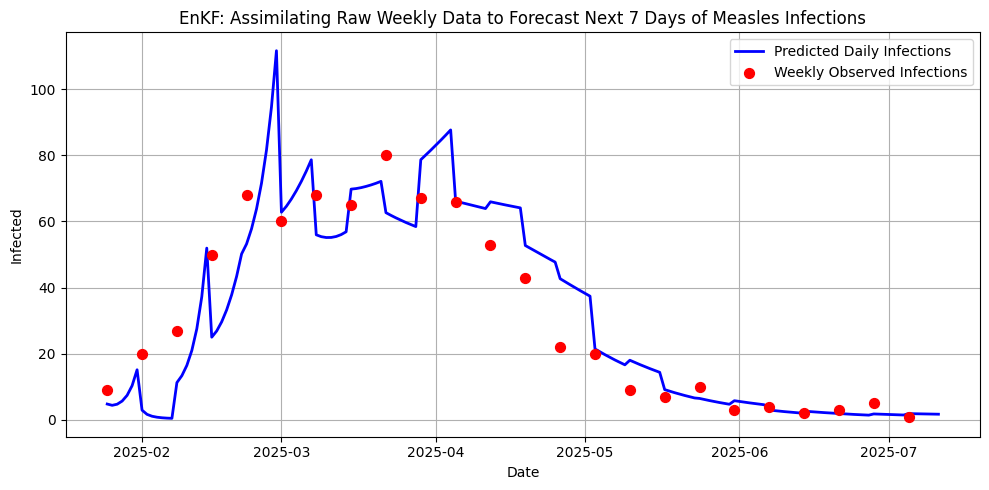

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example: daily predictions
start_date = merged_df['date'].min()  # or set manually if needed
dates = merged_df['date'].values
pred_dates = pd.date_range(start=start_date, periods=len(pred_I), freq='D')

# Plot daily predictions
plt.figure(figsize=(10, 5))
plt.plot(pred_dates, pred_I, label='Predicted Daily Infections', color='blue', linewidth=2)

# Overlay weekly observed points (scatter only at weekly dates)
plt.scatter(merged_df['date'], merged_df['Infected'], color='red', label='Weekly Observed Infections', zorder=5, s=50)

plt.title(f"EnKF: Assimilating Raw Weekly Data to Forecast Next 7 Days of Measles Infections")
plt.xlabel('Date')
plt.ylabel('Infected')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Actual and predicted over valid dates; align to weekly assimilation points
# pred_I: predicted DAILY infections from simulation (length may be > number of weekly points)
# merged_df['Infected']: weekly observed value; 
# Let's compare only at observed (weekly) points
assimilation_interval = 7  # weekly

# Get only points where you have valid weekly observations (and not nan)
weekly_dates = merged_df['date']
actual_I = merged_df['Infected'].values.astype(float)
n_weeks = len(actual_I)

# Pred values at weekly assimilation points
pred_I_weekly = pred_I[assimilation_interval-1::assimilation_interval][:n_weeks]

# Remove nans for calculation safety
mask = ~np.isnan(actual_I) & ~np.isnan(pred_I_weekly)
actual_use = actual_I[mask]
pred_use = pred_I_weekly[mask]

# RMSE and R2 calculation
rmse = np.sqrt(mean_squared_error(actual_use, pred_use))
r2 = r2_score(actual_use, pred_use)

print(f"RMSE (weekly infected): {rmse:.2f}")
print(f"R^2 (weekly infected): {r2:.4f}")


RMSE (weekly infected): 14.19
R^2 (weekly infected): 0.7267


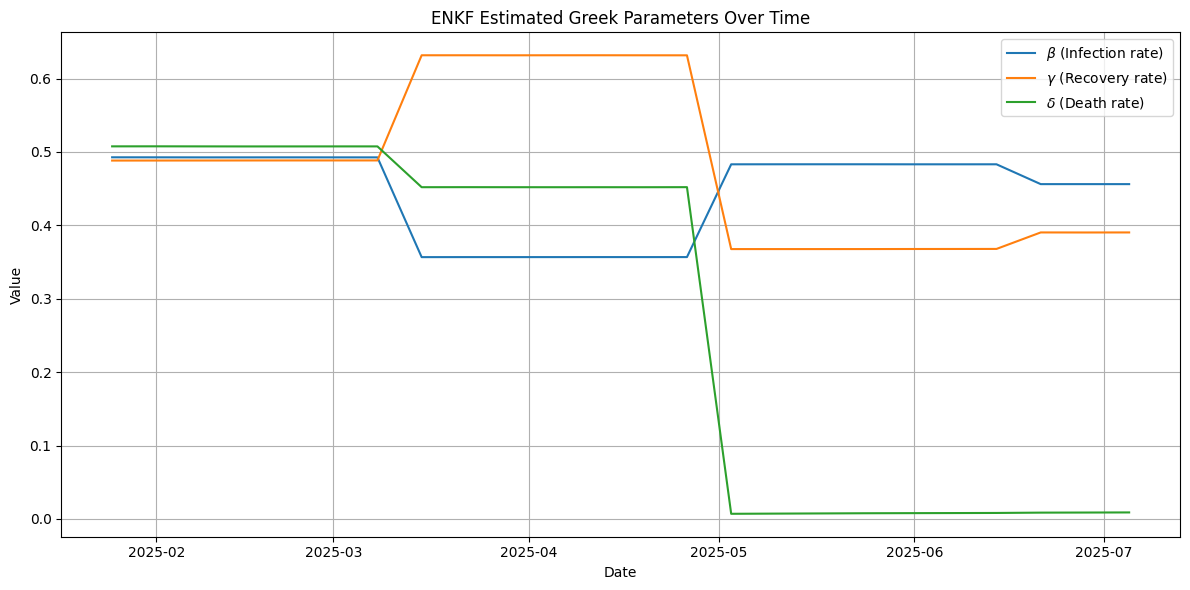

In [36]:
# Ensure dates and mean_states have same length
min_len = min(len(dates), mean_states.shape[0])
dates_to_plot = dates[:min_len]
beta = mean_states[:min_len, 3]
gamma = mean_states[:min_len, 4]
delta = mean_states[:min_len, 5]

plt.figure(figsize=(12,6))
plt.plot(dates_to_plot, beta, label=r'$\beta$ (Infection rate)')
plt.plot(dates_to_plot, gamma, label=r'$\gamma$ (Recovery rate)')
plt.plot(dates_to_plot, delta, label=r'$\delta$ (Death rate)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ENKF Estimated Greek Parameters Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ENKF SIM WITH CUMULATIVE DATA

In [29]:
# H = np.array([
#     [0, 0, 0, 0, 1],  # infected I
#     [0, 0, 0, 1, 0],  # deaths D
# ], dtype=float)  

# n_ens = 200
# dt = 1.0

# alpha = 1.0
# tol = 1e-3
# ens_perturb = 0.2

# # beta_ranges = [(0, 0.1), (0, 0.3), (0, 0.6), (0.4, 0.8), (0.5, 1)]

# beta_low, beta_high = 0, 1
# gamma_low, gamma_high = 0, 1 # recovery rate 
# delta_low, delta_high = 0, 1

In [30]:
# # N = pop_val*(exemption_val+((1-exemption_val)*(1-efficacy)))
# N = pop_val
# R0 = 0

# I0 = int(merged_df['Cumulative Infected'].iloc[0])
# D0 = int(merged_df['Cumulative Deaths'].iloc[0])
# C0 = int(merged_df['Cumulative Infected'].iloc[0])
# S0 = max(N - (I0 + R0 + D0), 0)

# x0_mean = np.array([S0, I0, R0, D0, C0])

# def R_from_obs(y_vec):
#     y = np.asarray(y_vec, dtype=float)
#     floors = np.array([0.005, 0.001])     # min std for C and D
#     sigma  = np.maximum(0.5*np.maximum(y, 1.0), floors)
#     return np.diag(sigma**2)

# def sird_step_aug(state_aug, N, dt):
#     S, I, R, D, C, beta, gamma, delta = state_aug
#     effective_beta = beta * (1 - ((1-exemption_val) * efficacy))
#     new_infections = effective_beta * S * I / N 
#     dS = -new_infections
#     dI = new_infections - gamma * I - delta * I
#     dR = gamma * I
#     dD = delta * I
#     S_new = max(S + dS * dt, 0)
#     I_new = max(I + dI * dt, 0)
#     R_new = max(R + dR * dt, 0)
#     D_new = max(D + dD * dt, 0)
#     C_new = C + new_infections

#     beta_new = beta + np.random.normal(0, 0.1e-4)
#     gamma_new = gamma + np.random.normal(0, 0.1e-4)
#     delta_new = delta + np.random.normal(0, 0.1e-4)

#     # constrain parameters to valid ranges
#     # beta_new = np.clip(beta_new, 0, 1)
#     # gamma_new = np.clip(gamma_new, 0, 1)
#     # delta_new = np.clip(delta_new, 0, 1)

#     return np.array([S_new, I_new, R_new, D_new, C_new, beta_new, gamma_new, delta_new])


# def enforce_mass(state_ens, N):
#     np.maximum(state_ens, 0.0, out=state_ens)
#     total_IRD = state_ens[:, 1:4].sum(axis=1)
#     ok = total_IRD <= N
#     state_ens[ok, 0] = N - total_IRD[ok]
#     over = ~ok
#     if np.any(over):
#         scale = (N / total_IRD[over])[:, None]
#         state_ens[over, 1:4] *= scale
#         state_ens[over, 0] = 0.0
#     return state_ens

# def predict_measurement(state_ensemble):
#     C = state_ensemble[:, 4]
#     D = state_ensemble[:, 3]
#     return np.column_stack([C, D])

# def clean_nans(y_true, y_pred):
#     mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
#     return y_true[mask], y_pred[mask]

In [31]:
# def run_enkf_weekly_cumulative(sim_seed, beta_low, beta_high):
#     rng = np.random.default_rng(sim_seed)
#     weekly_obs_df = merged_df.copy()  # still cumulative data

#     n_timesteps = len(weekly_obs_df)
#     assimilation_interval = 7  # weekly
#     dt_days = 1.0

#     Y_obs = weekly_obs_df[['Cumulative Infected', 'Cumulative Deaths']].to_numpy()

#     state_ens = np.zeros((n_ens, 8))
#     for i in range(n_ens):
#         perturb = 1 + ens_perturb * rng.normal(size=4)
#         IRD = np.maximum(x0_mean[1:4] * perturb[:3], 0)
#         S = max(N - IRD.sum(), 0)
#         beta = rng.uniform(beta_low, beta_high)
#         gamma = rng.uniform(gamma_low, gamma_high)
#         delta = rng.uniform(delta_low, delta_high)
#         C = x0_mean[4]
#         state_ens[i] = np.array([S, IRD[0], IRD[1], IRD[2], C, beta, gamma, delta])

#     ensemble_states_hist = np.full((n_timesteps, n_ens, 5), np.nan)
#     ensemble_params_hist = np.full((n_timesteps, n_ens, 3), np.nan)

#     for week_idx in range(0, n_timesteps, assimilation_interval):
#         for day_offset in range(assimilation_interval):
#             k = week_idx + day_offset
#             if k >= n_timesteps:
#                 break

#             # daily forecast propagation
#             for i in range(n_ens):
#                 state_ens[i] = sird_step_aug(state_ens[i], N, dt_days)
#             state_ens = enforce_mass(state_ens, N)
#             ensemble_states_hist[k] = state_ens[:, :5]
#             ensemble_params_hist[k] = state_ens[:, 5:]

#         # assimilation step (once a week)
#         k_obs = min(week_idx + assimilation_interval - 1, n_timesteps - 1)
#         y_obs_k = Y_obs[k_obs]

#         Rk = R_from_obs(y_obs_k)
#         meas_pred = predict_measurement(state_ens)
#         obs_perturbed = rng.multivariate_normal(y_obs_k, Rk, size=n_ens)

#         aug_ens = state_ens.copy()
#         aug_mean = np.mean(aug_ens, axis=0)
#         meas_mean = np.mean(meas_pred, axis=0)
#         X = aug_ens - aug_mean
#         Y = meas_pred - meas_mean
#         C_xy = (X.T @ Y) / (n_ens - 1)
#         C_yy = (Y.T @ Y) / (n_ens - 1)
#         Kk = C_xy @ np.linalg.inv(C_yy + Rk)

#         for i in range(n_ens):
#             innovation = obs_perturbed[i] - meas_pred[i]
#             state_ens[i] += alpha * (Kk @ innovation)
#         state_ens = enforce_mass(state_ens, N)
#         # cumulative monotonicity constraint
#         last_obs_C = y_obs_k[0]
#         state_ens[:, 4] = np.maximum(state_ens[:, 4], last_obs_C)

#         mean_beta = np.mean(state_ens[:, 5])
#         mean_gamma = np.mean(state_ens[:, 6])
#         mean_delta = np.mean(state_ens[:, 7])
#         print(f"Assimilation at day {k_obs}: mean beta={mean_beta:.4f}, gamma={mean_gamma:.4f}, delta={mean_delta:.4f}")

#     mean_states = np.nanmean(ensemble_states_hist, axis=1)
#     predicted_C = mean_states[:, 4]
#     actual_C = weekly_obs_df['Cumulative Infected'].to_numpy()
#     actual_D = weekly_obs_df['Cumulative Deaths'].to_numpy()
#     actual_C, pred_C = clean_nans(actual_C, predicted_C)
#     actual_D, pred_D = clean_nans(actual_D, mean_states[:, 3])

#     rmse_C = np.sqrt(root_mean_squared_error(actual_C, pred_C))
#     r2_C = r2_score(actual_C, pred_C)
#     rmse_D = np.sqrt(root_mean_squared_error(actual_D, pred_D))
#     r2_D = r2_score(actual_D, pred_D)

#     print(f"Cumulative Infected: RMSE {rmse_C:.2f}, R^2 {r2_C:.4f}")
#     print(f"Cumulative Deaths: RMSE {rmse_D:.2f}, R^2 {r2_D:.4f}")

#     return {
#         'rmse_C': rmse_C,
#         'r2_C': r2_C,
#         'rmse_D': rmse_D,
#         'r2_D': r2_D,
#         'ensemble_states_hist': ensemble_states_hist,
#         'ensemble_params_hist': ensemble_params_hist,
#         'mean_states': mean_states
#     }


In [32]:
# seeds = np.arange(10, 15)
# results = []
# for seed in seeds:
#     res = run_enkf_weekly_cumulative(seed, beta_low, beta_high)
#     results.append(res)

# result = results[0]
# ensemble_states_hist = result['ensemble_states_hist']
# mean_states = result['mean_states']
# ensemble_params_hist = result['ensemble_params_hist']

# # Parameter summaries
# mean_params_over_time = np.nanmean(ensemble_params_hist, axis=1)
# mean_beta_over_time = mean_params_over_time[:, 0]
# mean_gamma_over_time = mean_params_over_time[:, 1]
# mean_delta_over_time = mean_params_over_time[:, 2]


In [33]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Example: daily predictions
# start_date = merged_df['date'].min()  # or set manually if needed
# dates = merged_df['date'].values
# pred_dates = pd.date_range(start=start_date, periods=len(pred_I), freq='D')

# # Plot daily predictions
# plt.figure(figsize=(10, 5))
# plt.plot(pred_dates, pred_I, label='Predicted Daily Infections', color='blue', linewidth=2)

# # Overlay weekly observed points (scatter only at weekly dates)
# plt.scatter(merged_df['date'], merged_df['Cumulative Infected'], color='red', label='Weekly Observed Infections', zorder=5, s=50)

# plt.title(f"Predicted vs Weekly Observed Infections ({county_name})")
# plt.xlabel('Date')
# plt.ylabel('Infected')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [34]:
# # Ensure matching lengths
# min_len = min(len(dates), mean_states.shape[0])
# dates_to_plot = dates[:min_len]

# # mean state variables valid indices 0-4
# # Parameters are in ensemble_params_hist at indices 0,1,2 respectively for beta, gamma, delta

# mean_params_over_time = np.nanmean(ensemble_params_hist[:min_len], axis=1)  # average over ensembles

# beta = mean_params_over_time[:, 0]
# gamma = mean_params_over_time[:, 1]
# delta = mean_params_over_time[:, 2]

# plt.figure(figsize=(12,6))
# plt.plot(dates_to_plot, beta, label=r'$\beta$ (Infection rate)')
# plt.plot(dates_to_plot, gamma, label=r'$\gamma$ (Recovery rate)')
# plt.plot(dates_to_plot, delta, label=r'$\delta$ (Death rate)')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.title('Estimated Greek Parameters Over Time')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


# EKF ROLLOVER

In [26]:
import numpy as np

# -----------------------------
# Configuration (tweak freely)
# -----------------------------
DT = 1.0  # 1 day time step
# Parameter bounds
BETA_MIN, BETA_MAX = 0.0, 1.0
GAMMA_MIN, GAMMA_MAX = 0.05, 0.20
DELTA_MIN, DELTA_MAX = 0.0, 0.005

# Parameter random-walk process noise (small drifts)
Q_BETA = 1e-6
Q_GAMMA = 1e-7
Q_DELTA = 1e-8

# -----------------------------
# Helpers: models & jacobians
# -----------------------------
def f_continuous(x, N):
    """Continuous-time SIRD with static params (derivatives)."""
    S, I, D, beta, gamma, delta = x
    new_inf = beta * S * I / N
    dS = -new_inf
    dI = new_inf - gamma * I - delta * I
    dD = delta * I
    # parameters evolve via small random walk (handled in Q)
    return np.array([dS, dI, dD, 0.0, 0.0, 0.0], dtype=float)

def jacobian_F(x, N, dt=DT):
    """Discrete-time Jacobian via forward-Euler on continuous model."""
    S, I, D, beta, gamma, delta = x
    F = np.eye(6)
    # dS wrt S,I,beta
    F[0, 0] += (-beta * I / N) * dt
    F[0, 1] += (-beta * S / N) * dt
    F[0, 3] += ( -S * I / N) * dt
    # dI wrt S,I,beta,gamma,delta
    F[1, 0] += ( beta * I / N) * dt
    F[1, 1] += ( beta * S / N - gamma - delta) * dt
    F[1, 3] += ( S * I / N) * dt
    F[1, 4] += (-I) * dt
    F[1, 5] += (-I) * dt
    # dD wrt I,delta
    F[2, 1] += ( delta) * dt
    F[2, 5] += ( I) * dt
    return F

def compute_Q(x, N):
    """State-dependent process noise for S, I, D + tiny parameter drift."""
    S, I, D, beta, gamma, delta = x
    p1 = max(beta * S * I / N, 0.0)   # infection flow
    p2 = max(gamma * I, 0.0)          # recoveries (not tracked separately)
    p3 = max(delta * I, 0.0)          # deaths
    # Stoichiometry for (S,I,D): infection, recovery (I->R), death (I->D)
    lam1 = np.array([-1, +1,  0, 0, 0, 0])  # infection affects S,I
    lam2 = np.array([ 0, -1,  0, 0, 0, 0])  # recovery reduces I
    lam3 = np.array([ 0, -1, +1, 0, 0, 0])  # death moves I->D

    Q = (p1 * np.outer(lam1, lam1) +
         p2 * np.outer(lam2, lam2) +
         p3 * np.outer(lam3, lam3))
    # Parameter drifts
    Q[3,3] += Q_BETA
    Q[4,4] += Q_GAMMA
    Q[5,5] += Q_DELTA
    return Q

def h(x):
    """Measurement model: observe [I, D]."""
    return np.array([x[1], x[2]], dtype=float)

def jacobian_H():
    """Jacobian of h wrt state (constant)."""
    H = np.zeros((2, 6))
    H[0, 1] = 1.0  # I
    H[1, 2] = 1.0  # D
    return H

def R_from_obs(y_obs):
    """
    Observation covariance from value scale.
    If a component is NaN, we return a large variance for that channel
    and will optionally drop that channel in the update.
    """
    y = np.asarray(y_obs, float)
    # 10% relative stdev with floors
    floors = np.array([0.05, 0.01])  # absolute floors for I,D (stdev)
    sigma = np.maximum(0.10 * np.maximum(y, 1.0), floors)
    return np.diag(sigma**2)

def clip_state(x, N):
    """Nonnegativity, simple mass-balance on S, and param bounds."""
    x = np.maximum(x, 0.0)
    S, I, D, beta, gamma, delta = x
    # Keep S >= 0 and S <= N - (I + D); if violated, adjust S
    total_ID = I + D
    if total_ID > N:
        # scale I and D down proportionally
        scale = N / max(total_ID, 1e-12)
        I *= scale
        D *= scale
        S = 0.0
    else:
        S = N - total_ID
    # Parameter clipping
    beta  = np.clip(beta,  BETA_MIN,  BETA_MAX)
    gamma = np.clip(gamma, GAMMA_MIN, GAMMA_MAX)
    delta = np.clip(delta, DELTA_MIN, DELTA_MAX)
    x[:3] = [S, I, D]
    x[3:] = [beta, gamma, delta]
    return x

# -----------------------------
# Main routine
# -----------------------------
def run_ekf_weekly_assimilation(N, weekly_obs_df):
    """
    Weekly EKF:
      - Predict daily for 7 steps
      - Assimilate once using the week's [Infected, Deaths]
    Inputs:
      N: population (float or int)
      weekly_obs_df: DataFrame with columns ['date','Infected','Deaths']
                     ordered by time, one row per week.
    Returns:
      x_hist: (T_days, 6) daily filtered states [S,I,D,beta,gamma,delta]
      P_hist: (T_days, 6, 6) daily covariances
      day_to_week_idx: (T_days,) mapping day index -> week index
    """
    weekly_obs_df = weekly_obs_df.reset_index(drop=True)
    n_weeks = len(weekly_obs_df)
    days_per_week = 7
    T_days = n_weeks * days_per_week

    # ----- Init from first weekly obs -----
    I0 = float(weekly_obs_df['Infected'].iloc[0])
    D0 = float(weekly_obs_df['Deaths'].iloc[0])
    S0 = float(max(N - I0 - D0, 0.0))

    # Reasonable starting params (adjust as you like)
    beta0, gamma0, delta0 = 0.2, 0.5, 0.01
    x = np.array([S0, I0, D0, beta0, gamma0, delta0], dtype=float)

    # Covariance init (tune as needed)
    P = np.diag([
        (0.05 * max(S0, 1.0))**2,  # S
        (0.20 * max(I0, 1.0))**2,  # I
        (0.20 * max(D0, 1.0))**2,  # D
        1e-2,  # beta
        1e-3,  # gamma
        1e-4   # delta
    ])

    # Storage
    x_hist = np.zeros((T_days, 6))
    P_hist = np.zeros((T_days, 6, 6))
    day_to_week_idx = np.zeros(T_days, dtype=int)

    H_full = jacobian_H()

    day = 0
    for wk in range(n_weeks):
        # --- 7 daily predictions ---
        for d in range(days_per_week):
            # Predict (discrete Euler step)
            f_x = f_continuous(x, N)
            x_pred = x + f_x * DT

            F = jacobian_F(x, N, DT)
            Qk = compute_Q(x, N)
            P_pred = F @ P @ F.T + Qk

            # Save prediction now; if it’s the assimilation day, we’ll update after
            x = clip_state(x_pred, N)
            P = P_pred

            # Record current day (post-predict)
            x_hist[day] = x
            P_hist[day] = P
            day_to_week_idx[day] = wk
            day += 1

        # --- Weekly assimilation (use obs at this week) ---
        y = weekly_obs_df.loc[wk, ['Infected', 'Deaths']].to_numpy(dtype=float)
        Rk = R_from_obs(y)

        # Handle NaNs: drop missing channels from update
        obs_mask = ~np.isnan(y)
        if np.any(obs_mask):  # only update if at least one channel present
            y_sub = y[obs_mask]
            H_sub = H_full[obs_mask, :]              # rows for observed channels
            R_sub = Rk[np.ix_(obs_mask, obs_mask)]

            z_pred = H_sub @ x
            S_mat = H_sub @ P @ H_sub.T + R_sub
            K = P @ H_sub.T @ np.linalg.inv(S_mat)
            innovation = y_sub - z_pred

            x_upd = x + K @ innovation
            # Joseph form covariance update for better numerics
            I6 = np.eye(6)
            P_upd = (I6 - K @ H_sub) @ P @ (I6 - K @ H_sub).T + K @ R_sub @ K.T

            x = clip_state(x_upd, N)
            P = P_upd
            # Overwrite the last day of the week with the post-update state
            last_day = wk * days_per_week + (days_per_week - 1)
            x_hist[last_day] = x
            P_hist[last_day] = P

    return x_hist, P_hist, day_to_week_idx


setting gamma and delta constant but same as above

In [5]:
import numpy as np

# -----------------------------
# Configuration (tweak freely)
# -----------------------------
DT = 1.0  # 1 day time step

# Fixed parameters (constants throughout the sim)
GAMMA_CONST = 0.15
DELTA_CONST = 2/210

# Parameter bounds (only beta is estimated)
BETA_MIN, BETA_MAX = 0.0, 1.0

# Parameter random-walk process noise (small drift for beta only)
Q_BETA = 1e-6

# -----------------------------
# Helpers: models & jacobians
# -----------------------------
def f_continuous(x, N):
    """
    Continuous-time SIRD with fixed gamma, delta.
    State x = [S, I, D, beta].
    """
    S, I, D, beta = x
    gamma = GAMMA_CONST
    delta = DELTA_CONST

    new_inf = beta * S * I / N
    dS = -new_inf
    dI = new_inf - gamma * I - delta * I
    dD = delta * I
    # beta evolves via small random walk (handled by Q)
    return np.array([dS, dI, dD, 0.0], dtype=float)

def jacobian_F(x, N, dt=DT):
    """
    Discrete-time Jacobian via forward-Euler on continuous model.
    State x = [S, I, D, beta].
    """
    S, I, D, beta = x
    gamma = GAMMA_CONST
    delta = DELTA_CONST

    F = np.eye(4)
    # dS wrt S, I, beta
    F[0, 0] += (-beta * I / N) * dt
    F[0, 1] += (-beta * S / N) * dt
    F[0, 3] += (-S * I / N) * dt
    # dI wrt S, I, beta
    F[1, 0] += ( beta * I / N) * dt
    F[1, 1] += ( beta * S / N - gamma - delta) * dt
    F[1, 3] += ( S * I / N) * dt
    # dD wrt I
    F[2, 1] += ( delta) * dt
    # beta row already identity (random walk handled in Q)
    return F

def compute_Q(x, N):
    """
    State-dependent process noise for S, I, D + tiny parameter drift for beta.
    State x = [S, I, D, beta].
    """
    S, I, D, beta = x
    gamma = GAMMA_CONST
    delta = DELTA_CONST

    p1 = max(beta * S * I / N, 0.0)   # infection flow (S->I)
    p2 = max(gamma * I, 0.0)          # recovery flow (I->R) — not tracked, reduces I
    p3 = max(delta * I, 0.0)          # death flow (I->D)

    # Stoichiometry in (S, I, D, beta) coordinates:
    lam1 = np.array([-1, +1,  0, 0])  # infection affects S,I
    lam2 = np.array([ 0, -1,  0, 0])  # recovery reduces I
    lam3 = np.array([ 0, -1, +1, 0])  # death moves I->D

    Q = (p1 * np.outer(lam1, lam1) +
         p2 * np.outer(lam2, lam2) +
         p3 * np.outer(lam3, lam3))

    # Parameter drift for beta
    Q[3, 3] += Q_BETA
    return Q

def h(x):
    """Measurement model: observe [I, D] from state [S, I, D, beta]."""
    return np.array([x[1], x[2]], dtype=float)

def jacobian_H():
    """Jacobian of h wrt state (constant)."""
    H = np.zeros((2, 4))
    H[0, 1] = 1.0  # I
    H[1, 2] = 1.0  # D
    return H

def R_from_obs(y_obs):
    """
    Observation covariance from value scale.
    If a component is NaN, we return a large variance for that channel
    and optionally drop that channel in the update.
    """
    y = np.asarray(y_obs, float)
    # 10% relative stdev with floors
    floors = np.array([0.05, 0.01])  # absolute floors for I,D (stdev)
    sigma = np.maximum(0.10 * np.maximum(y, 1.0), floors)
    return np.diag(sigma**2)

def clip_state(x, N):
    """
    Nonnegativity, simple mass-balance on S, and param bounds for beta only.
    We enforce S = N - (I + D) to keep a closed S+I+R+D=N without tracking R.
    """
    x = np.maximum(x, 0.0)
    S, I, D, beta = x

    total_ID = I + D
    if total_ID > N:
        # scale I and D down proportionally
        scale = N / max(total_ID, 1e-12)
        I *= scale
        D *= scale
        S = 0.0
    else:
        S = N - total_ID

    beta = np.clip(beta, BETA_MIN, BETA_MAX)

    x[:3] = [S, I, D]
    x[3]  = beta
    return x

# -----------------------------
# Main routine
# -----------------------------
def run_ekf_weekly_assimilation(N, weekly_obs_df):
    """
    Weekly EKF with fixed gamma=0.15 and delta=0.01, estimating only beta.
      - Predict daily for 7 steps
      - Assimilate once using the week's [Infected, Deaths]
    Inputs:
      N: population (float or int)
      weekly_obs_df: DataFrame with columns ['date','Infected','Deaths']
                     ordered by time, one row per week.
    Returns:
      x_hist: (T_days, 4) daily filtered states [S, I, D, beta]
      P_hist: (T_days, 4, 4) daily covariances
      day_to_week_idx: (T_days,) mapping day index -> week index
    """
    weekly_obs_df = weekly_obs_df.reset_index(drop=True)
    n_weeks = len(weekly_obs_df)
    days_per_week = 7
    T_days = n_weeks * days_per_week

    # ----- Init from first weekly obs -----
    I0 = float(weekly_obs_df['Infected'].iloc[0])
    D0 = float(weekly_obs_df['Deaths'].iloc[0])
    S0 = float(max(N - I0 - D0, 0.0))

    # Start beta reasonably; gamma, delta are fixed
    beta0 = 0.2
    x = np.array([S0, I0, D0, beta0], dtype=float)

    # Covariance init (tune as needed)
    P = np.diag([
        (0.05 * max(S0, 1.0))**2,  # S
        (0.20 * max(I0, 1.0))**2,  # I
        (0.20 * max(D0, 1.0))**2,  # D
        1e-2                        # beta
    ])

    # Storage
    x_hist = np.zeros((T_days, 4))
    P_hist = np.zeros((T_days, 4, 4))
    day_to_week_idx = np.zeros(T_days, dtype=int)

    H_full = jacobian_H()

    day = 0
    for wk in range(n_weeks):
        # --- 7 daily predictions ---
        for d in range(days_per_week):
            # Predict (discrete Euler step)
            f_x = f_continuous(x, N)
            x_pred = x + f_x * DT

            F = jacobian_F(x, N, DT)
            Qk = compute_Q(x, N)
            P_pred = F @ P @ F.T + Qk

            # Save prediction now; if it’s the assimilation day, we’ll update after
            x = clip_state(x_pred, N)
            P = P_pred

            # Record current day (post-predict)
            x_hist[day] = x
            P_hist[day] = P
            day_to_week_idx[day] = wk
            day += 1

        # --- Weekly assimilation (use obs at this week) ---
        y = weekly_obs_df.loc[wk, ['Infected', 'Deaths']].to_numpy(dtype=float)
        Rk = R_from_obs(y)

        # Handle NaNs: drop missing channels from update
        obs_mask = ~np.isnan(y)
        if np.any(obs_mask):  # only update if at least one channel present
            y_sub = y[obs_mask]
            H_sub = H_full[obs_mask, :]              # rows for observed channels
            R_sub = Rk[np.ix_(obs_mask, obs_mask)]

            z_pred = H_sub @ x
            S_mat = H_sub @ P @ H_sub.T + R_sub
            K = P @ H_sub.T @ np.linalg.inv(S_mat)
            innovation = y_sub - z_pred

            x_upd = x + K @ innovation
            # Joseph form covariance update for better numerics
            I4 = np.eye(4)
            P_upd = (I4 - K @ H_sub) @ P @ (I4 - K @ H_sub).T + K @ R_sub @ K.T

            x = clip_state(x_upd, N)
            P = P_upd

            # Overwrite the last day of the week with the post-update state
            last_day = wk * days_per_week + (days_per_week - 1)
            x_hist[last_day] = x
            P_hist[last_day] = P

    return x_hist, P_hist, day_to_week_idx


In [6]:
# --- Prepare weekly input for EKF ---
weekly_obs_df = merged_df[['date', 'Infected', 'Deaths']].copy().sort_values('date').reset_index(drop=True)

# --- Run EKF assimilation ---
x_hist, P_hist, day_to_week_idx = run_ekf_weekly_assimilation(N, weekly_obs_df)


In [7]:
import pandas as pd

start_date = weekly_obs_df['date'].iloc[0]
n_days = len(x_hist)
pred_dates = pd.date_range(start=start_date, periods=n_days, freq='D')

# daily predicted infections
pred_I = x_hist[:, 1]


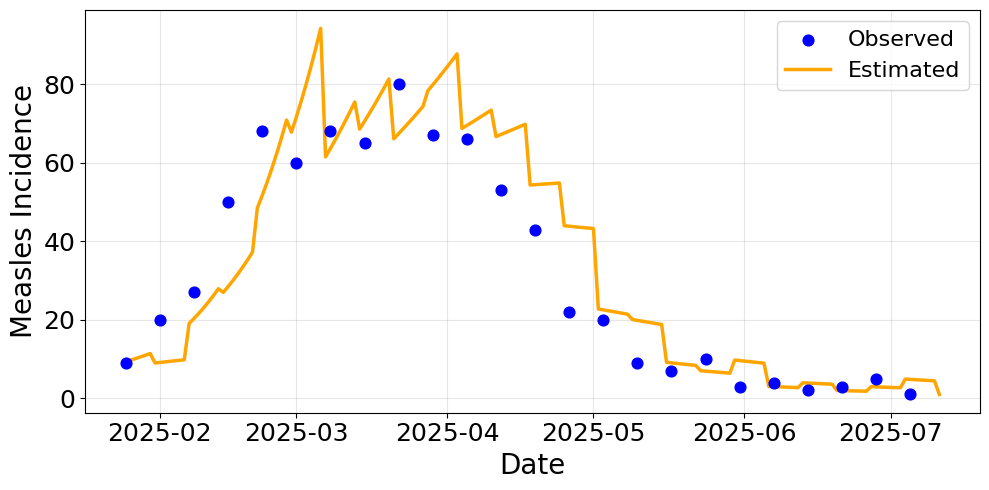

In [16]:
import matplotlib.pyplot as plt

# --- Font and layout settings ---
title_size = 24
axis_size = 20
x_label = 18
legend = 16

# --- Plot weekly observed vs predicted infections ---
fig, ax = plt.subplots(figsize=(10, 5))

# Observed (weekly scatter)
ax.scatter(
    weekly_obs_df['date'], weekly_obs_df['Infected'],
    label="Observed", s=60, color='blue', zorder=5
)

# Predicted (continuous line)
ax.plot(pred_dates, pred_I, label="Estimated", color='orange', linewidth=2.5)

# Axis labels and formatting
ax.set_xlabel("Date", fontsize=axis_size)
ax.set_ylabel("Measles Incidence", fontsize=axis_size)
# ax.set_title(f"{title}:\nPredicted Infections vs Observed Infectious Cases", fontsize=title_size)

ax.tick_params(axis='both', labelsize=x_label)
ax.legend(fontsize=legend)
ax.grid(alpha=0.3)
plt.tight_layout()

# --- SAVE OPTIONS FOR POWERPOINT ---
# Option 1 (best): Vector PDF – razor-sharp at any zoom
plt.savefig("weekly_prediction.pdf", bbox_inches="tight")

# Option 2: Editable vector (PowerPoint 365 / Illustrator)
plt.savefig("weekly_prediction.svg", bbox_inches="tight")

# Option 3: High-resolution raster fallback
plt.savefig("weekly_prediction.png", dpi=600, bbox_inches="tight")

plt.show()



In [9]:

from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

# predicted infection at weekly assimilation times
pred_weekly_I = x_hist[6::7, 1]   # every 7th day corresponds to an assimilation
obs_weekly_I = weekly_obs_df['Infected'].to_numpy()

# drop NaN pairs if any
mask = ~np.isnan(obs_weekly_I) & ~np.isnan(pred_weekly_I)
rmse_I = root_mean_squared_error(obs_weekly_I[mask], pred_weekly_I[mask])
r2_I = r2_score(obs_weekly_I[mask], pred_weekly_I[mask])

print(f"RMSE (weekly infections): {rmse_I:.3f}")
print(f"R² (weekly infections):   {r2_I:.4f}")


RMSE (weekly infections): 0.833
R² (weekly infections):   0.9991


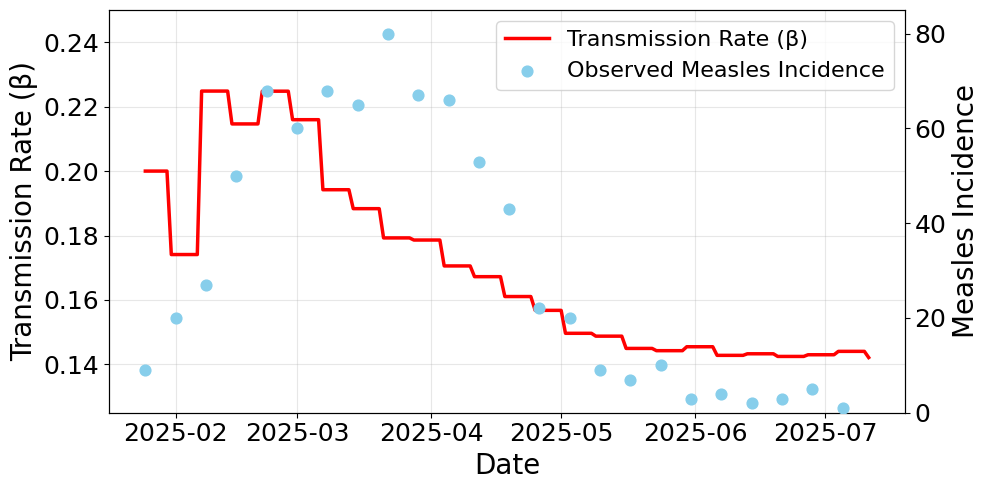

: 

In [ ]:
import matplotlib.pyplot as plt

# --- Font and style settings ---
title_size = 24
axis_size = 20
x_label = 18
legend = 16

# --- Extract and align data ---
beta_est = x_hist[:, 3]          # β over time
pred_I   = x_hist[:, 1]          # daily predicted infections
min_len  = min(len(pred_dates), len(beta_est))

# --- Create figure ---
fig, ax1 = plt.subplots(figsize=(10, 5))

# --- Left y-axis: Transmission Rate (β) ---
ax1.plot(
    pred_dates[:min_len], beta_est[:min_len],
    label='Transmission Rate (β)', linewidth=2.5, color='red'
)
ax1.set_xlabel('Date', fontsize=axis_size)
ax1.set_ylabel('Transmission Rate (β)', fontsize=axis_size)
ax1.set_ylim(0.125, 0.25)   # adjust if β range differs
ax1.grid(alpha=0.3)
ax1.tick_params(axis='both', labelsize=x_label)

# --- Right y-axis: Observed weekly infections ---
ax2 = ax1.twinx()
ax2.scatter(
    weekly_obs_df['date'], weekly_obs_df['Infected'],
    label='Observed Measles Incidence', s=60, zorder=5, color='skyblue'
)
ax2.set_ylabel('Measles Incidence', fontsize=axis_size)
ax2.set_ylim(0, 85)
ax2.tick_params(axis='both', labelsize=x_label)

# --- Combined legend ---
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=legend)

# --- Layout and export ---
plt.tight_layout()

# Option 1 (best): Vector PDF – perfectly crisp in PowerPoint
plt.savefig("beta_vs_infections.pdf", bbox_inches="tight")

# Option 2: Editable vector – for PowerPoint 365 or Illustrator
plt.savefig("beta_vs_infections.svg", bbox_inches="tight")

# Option 3: High-resolution raster fallback
plt.savefig("beta_vs_infections.png", dpi=600, bbox_inches="tight")

plt.show()


In [11]:
print(beta_est)

[0.2        0.2        0.2        0.2        0.2        0.2
 0.17409692 0.17409692 0.17409692 0.17409692 0.17409692 0.17409692
 0.17409692 0.22483663 0.22483663 0.22483663 0.22483663 0.22483663
 0.22483663 0.22483663 0.21463939 0.21463939 0.21463939 0.21463939
 0.21463939 0.21463939 0.21463939 0.22479689 0.22479689 0.22479689
 0.22479689 0.22479689 0.22479689 0.22479689 0.21595171 0.21595171
 0.21595171 0.21595171 0.21595171 0.21595171 0.21595171 0.19421572
 0.19421572 0.19421572 0.19421572 0.19421572 0.19421572 0.19421572
 0.1883383  0.1883383  0.1883383  0.1883383  0.1883383  0.1883383
 0.1883383  0.17925923 0.17925923 0.17925923 0.17925923 0.17925923
 0.17925923 0.17925923 0.17860023 0.17860023 0.17860023 0.17860023
 0.17860023 0.17860023 0.17860023 0.17056141 0.17056141 0.17056141
 0.17056141 0.17056141 0.17056141 0.17056141 0.16722819 0.16722819
 0.16722819 0.16722819 0.16722819 0.16722819 0.16722819 0.16106081
 0.16106081 0.16106081 0.16106081 0.16106081 0.16106081 0.16106081
 0.